In [1]:
import os.path
import re
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation
from matplotlib.animation import FuncAnimation
import yt
import glob
import pandas as pd
import math
import scipy.integrate as integrate
from matplotlib.backends.backend_pdf import PdfPages
mpl.rcParams['figure.dpi'] = 400

In [2]:
def tophat(x,center,amplitude,width,eta,t):
    convected_distance = 1.0 * t # assumes unit convection velocity
    if (abs((x-convected_distance) - center) < 0.5 * width):
        return amplitude
    else:
        return 0.0

In [3]:
def gaussian(x,center,amplitude,width,eta,t):
    convected_distance = 1.0 * t # assumes unit convection velocity
    if (abs((x-convected_distance) - center) < 6 * width):
        return amplitude * math.exp( - ((x - convected_distance) - center) ** 2 / (2 * width ** 2))
    else:
        return 0.0

In [4]:
def yalla2021(x,center,amplitude,width,eta,t):
    convected_distance = 1.0 * t # assumes unit convection velocity
    if (abs((x-convected_distance) - center) < 6 * width):
        return math.cos(eta * (x-convected_distance)) * amplitude * math.exp( - ((x-convected_distance) - center) ** 2 / (2 * width ** 2))
    else:
        return 0.0

In [5]:
def tophatfv(func,x,dx,center,amplitude,width,eta,t):
    convected_distance = 1.0 * t # assumes unit convection velocity
    if (abs(abs((x-convected_distance) - center) - width / 2) < dx / 2) :
        return amplitude * (width / 2 - abs((x-convected_distance) - center) + dx / 2) / dx
    elif (abs((x-convected_distance) - center) < width / 2) :
        return amplitude
    else :
        return 0.0

In [6]:
def natural_sort(l):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split("([0-9]+)", key)]
    return sorted(l, key=alphanum_key)

In [7]:
def exact_sol_cell_average_scipy(func,x,dx,center,amplitude,width,eta,t) :
    integral = integrate.quad(func,x-dx/2,x+dx/2,args=(center,amplitude,width,eta,t))
    return integral[0]/dx

In [8]:
def exact_sol_cell_average_GLQ(func,x,dx,center,amplitude,width,eta,t) :
    w_i = [0.5555555556, 0.8888888889, 0.5555555556]
    dx_i = [-0.7745966692, 0, 0.7745966692]
    s = 0.0
    for i in range(len(w_i)) :
        s += w_i[i] * func(x + dx_i[i]*dx/2, center, amplitude, width, eta, t)
    return s/2

In [11]:
color_list = [
    "#EE2E2F",
    "#008C48",
    "#185AA9",
    "#F47D23",
    "#662C91",
    "#A21D21",
    "#B43894",
    "#010202",
]
linestyle_list = [
    "solid",
    "dashed",
    "dotted",
    "dashdot"
]
linewidth_list = [
    1.5,
    0.5
]

In [12]:
def postprocess_dist(case,idx,rootdir,methods,grid_types,grid_sizes,
                ax,line_styles,line_colors,line_widths,plotting,line_configuration):
    
    i_method = -1
    for method in methods:
        i_method += 1
        i_grid_type = -1
        for grid_type in grid_types:
            i_grid_type += 1
            i_grid_size = -1
            for grid_size in grid_sizes:
                i_grid_size += 1

                case_dir = os.path.join(root_dir, method, case, grid_type, f'nx_{grid_size}')

                # Load plt files
                plt_files = natural_sort(glob.glob(os.path.join(case_dir, "plt*")))
                
                ds = yt.load(plt_files[idx])
                ray = ds.ortho_ray(0, (0, 0))
                srt = np.argsort(ray["x"])
                df = pd.DataFrame({f: np.array(ray[f][srt]) for f in ["x","temperature"]})
                t = ds.current_time.value.flatten()[0]
                df["time"] = t
                df["dx"] = [ray.fwidth[i][0].value.flatten()[0] for i in range(len(df["x"].values))]
                
                # Plot scalar distribution
                if plotting == True:
                    if line_configuration == 1:
                        ax.plot(df["x"].values, df["temperature"].values, label=f'{method}; nx = {grid_size}; grid type = {grid_type}; t = {t}', color=line_colors[i_grid_size], linewidth=line_widths[i_grid_type], linestyle=line_styles[i_method])
                    else:
                        ax.plot(df["x"].values, df["temperature"].values, label=f'{method}; nx = {grid_size}; grid type = {grid_type}; t = {t}', color=line_colors[i_method], linewidth=line_widths[i_grid_type], linestyle=line_styles[i_grid_size])
    return t, df["x"].values, df["temperature"].values
            

In [175]:
def postprocess_error(case,t,rootdir,methods,grid_types,grid_sizes,
                ax,line_styles,line_colors,line_widths,plotting,line_configuration):
    
    i_method = -1
    for method in methods:
        i_method += 1
        i_grid_type = -1
        for grid_type in grid_types:
            i_grid_type += 1
            i_grid_size = -1
            for grid_size in grid_sizes:
                i_grid_size += 1

                case_dir = os.path.join(root_dir, method, case, grid_type, f'nx_{grid_size}')

                error_file = os.path.join(case_dir,'error.log')
                with open(error_file) as f:
                    lines = f.readlines()
                    error_levels = len(lines[1].split())-1
                    time = [float(line.split()[0]) for line in lines]
                    idx = time.index(min(time, key=lambda x:abs(x-t)))+1
                    
                    errors = []

                    for level in reversed(range(error_levels)):
                        errors.append([float(line.split()[level+1]) for line in lines][:idx])

                    for level in range(error_levels):
                        if line_configuration == 1:
                            ax.plot(time[:idx], errors[level], label=f'{method}; nx = {grid_size}; grid type = {grid_type}', color=line_colors[i_grid_size], linewidth=line_widths[i_grid_type], linestyle=line_styles[i_method])
                        else:
                            ax.plot(time[:idx], errors[level], label=f'{method}; nx = {grid_size}; grid type = {grid_type}', color=line_colors[i_method], linewidth=line_widths[i_grid_type], linestyle=line_styles[i_grid_size])
    
    return time[:idx], errors
            

In [14]:
def postprocess_convergence(case,idx,rootdir,methods,grid_types,grid_sizes,
                ax,line_styles,line_colors,line_widths,line_configuration):
    
    dx_list = [1.0/grid_size for grid_size in grid_sizes]

    i_method = -1
    for method in methods:
        i_method += 1
        i_grid_type = -1
        for grid_type in grid_types:
            i_grid_type += 1
            i_grid_size = -1
            
            error_list = []
            
            for grid_size in grid_sizes:
                i_grid_size += 1

                case_dir = os.path.join(root_dir, method, case, grid_type, f'nx_{grid_size}')

                error_file = os.path.join(case_dir,'error.log')
                
                with open(error_file) as f:
                    lines = f.readlines()
                    error = float(lines[-1].split()[-1])
                    
                error_list.append(error)
        if line_configuration == 1:
            ax.plot(dx_list, error_list, label=f'{method}; grid type = {grid_type}',linestyle=line_styles[i_method],linewidth=line_widths[i_grid_type],color='black')
        else :
            ax.plot(dx_list, error_list, label=f'{method}; grid type = {grid_type}',linestyle=line_styles[i_method],linewidth=line_widths[i_grid_type],color=line_colors[i_method])

                

# Animation to show scalar advection case

In [20]:
root_dir = '/Users/dbeckers/scalar_advection'

In [21]:
center = 0.25
amplitude = 1.0
width = 0.0251646060
# width = 0.05
# width = 0.01
eta = 226.1946710304
# t_final = 0.5
function = yalla2021

In [22]:
%%capture
plt.rcParams["animation.html"] = "jshtml"

x_exact = np.linspace(0, 1, num=500)
n_frames = 20

fig = plt.figure()
ax = plt.axes(xlim=(0, 1), ylim=(-1.3, 1.3))
ax.set_xlabel('x')
ax.set_ylabel('scalar')
line, = ax.plot([], [], color='red',linewidth=1)

def init():
    line.set_data([], [])
    return line,
def animate(i):
    t = i/(n_frames-1)*0.5
    scalar_exact = [function(x_i,center,amplitude,width,eta,t) for x_i in x_exact]
    line.set_data(x_exact, scalar_exact)
    return line,

anim = FuncAnimation(fig, animate, init_func=init, frames=n_frames, interval=100, blit=True)
# anim.save('1-scalar_advection_case.gif')

In [23]:
anim

# Uniform grid: different methods with nx = 512

### Initial timestep

In [24]:
lw_exact = 0.5
ls_exact = 'dashed'

yt : [INFO     ] 2022-08-07 13:00:09,294 Parameters: current_time              = 0.0
yt : [INFO     ] 2022-08-07 13:00:09,296 Parameters: domain_dimensions         = [512   4   4]
yt : [INFO     ] 2022-08-07 13:00:09,301 Parameters: domain_left_edge          = [ 0.         -0.00390625 -0.00390625]
yt : [INFO     ] 2022-08-07 13:00:09,309 Parameters: domain_right_edge         = [1.         0.00390625 0.00390625]
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421:

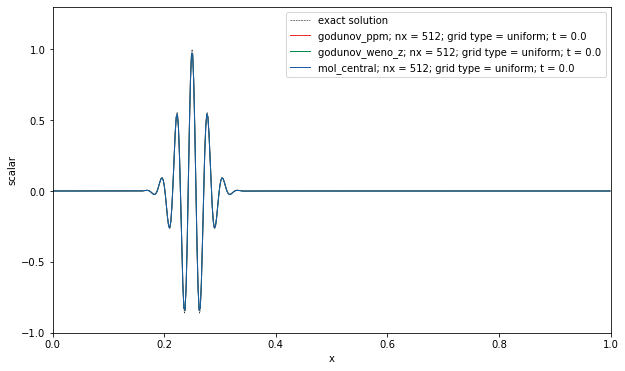

In [26]:
fig, ax = plt.subplots(figsize=(10, 6))

x_exact = np.linspace(0, 1, num=1000)
scalar_exact = [function(x_i,center,amplitude,width,eta,0) for x_i in x_exact]
ax.plot(x_exact,scalar_exact,color='black',label='exact solution',linewidth=lw_exact,linestyle=ls_exact)

postprocess_dist('yalla2021/eta_2',0,root_dir,['godunov_ppm','godunov_weno_z','mol_central'],['uniform'],[512],
                 ax,linestyle_list,color_list,[1.0],True,2)

ax.legend()
ax.set_xlim([0,1])
ax.set_ylim([-1.0,1.3])
ax.set_xlabel('x')
ax.set_ylabel('scalar')

fig.savefig('3-scalar_advection_uniform_initial.png')

### Final timestep

yt : [INFO     ] 2022-08-07 13:04:15,223 Parameters: current_time              = 0.5
yt : [INFO     ] 2022-08-07 13:04:15,226 Parameters: domain_dimensions         = [512   4   4]
yt : [INFO     ] 2022-08-07 13:04:15,233 Parameters: domain_left_edge          = [ 0.         -0.00390625 -0.00390625]
yt : [INFO     ] 2022-08-07 13:04:15,237 Parameters: domain_right_edge         = [1.         0.00390625 0.00390625]
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421:

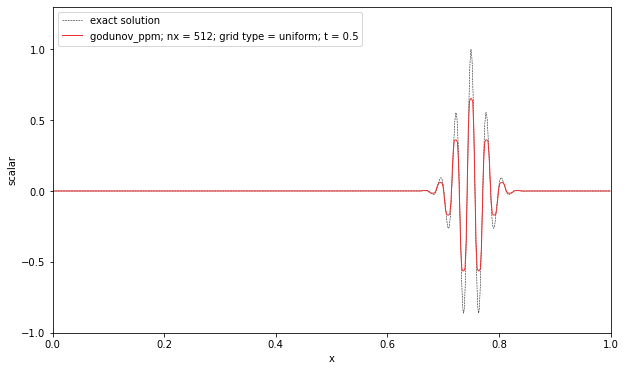

In [39]:
fig, ax = plt.subplots(figsize=(10, 6))

x_exact = np.linspace(0, 1, num=1000)
scalar_exact = [function(x_i,center,amplitude,width,eta,0.5) for x_i in x_exact]
ax.plot(x_exact,scalar_exact,color='black',label='exact solution',linewidth=lw_exact,linestyle=ls_exact)

postprocess_dist('yalla2021/eta_2',-1,root_dir,['godunov_ppm'],['uniform'],[512],
                 ax,linestyle_list,color_list,[1.0],True,2)

ax.legend(loc='upper left')
ax.set_xlim([0,1])
ax.set_ylim([-1.0,1.3])
ax.set_xlabel('x')
ax.set_ylabel('scalar')

fig.savefig('4a-scalar_advection_uniform_final_godunov_ppm.png')

In [151]:
%%capture
plt.rcParams["animation.html"] = "jshtml"

x_exact = np.linspace(0, 1, num=500)
n_frames = 9

fig = plt.figure()
ax = plt.axes(xlim=(0, 1), ylim=(-1, 1.3))
ax.set_xlabel('x')
ax.set_ylabel('scalar')

lines = []
line1 = ax.plot([],[],color='black',label='exact solution',linewidth=lw_exact,linestyle=ls_exact)[0]
lines.append(line1)
line2 = ax.plot([],[],color='red',label='godunov_ppm; nx = 512; grid type = uniform;',linewidth=1.0,linestyle='solid')[0]
lines.append(line2)
ax.legend(loc='upper left')

t_list = [0.0 for i in range(n_frames)]

def init():
    for line in lines:
        line.set_data([],[])
    return lines

def animate(i):
    t,x,s = postprocess_dist('yalla2021/eta_2',i,root_dir,['godunov_ppm'],['uniform'],[512],
                 ax,linestyle_list,color_list,[1.0],False,2)
    t_list[i] = t
    lines[1].set_data(x,s)
    scalar_exact = [function(x_i,center,amplitude,width,eta,t) for x_i in x_exact]
    lines[0].set_data(x_exact,scalar_exact)
    return lines

anim = FuncAnimation(fig, animate, init_func=init, frames=n_frames, interval=200, blit=True)
anim.save('4a-scalar_advection_uniform_final_godunov_ppm.gif')

yt : [INFO     ] 2022-08-07 13:46:46,516 Parameters: current_time              = 0.0
yt : [INFO     ] 2022-08-07 13:46:46,519 Parameters: domain_dimensions         = [512   4   4]
yt : [INFO     ] 2022-08-07 13:46:46,525 Parameters: domain_left_edge          = [ 0.         -0.00390625 -0.00390625]
yt : [INFO     ] 2022-08-07 13:46:46,529 Parameters: domain_right_edge         = [1.         0.00390625 0.00390625]
yt : [INFO     ] 2022-08-07 13:46:48,529 Parameters: current_time              = 0.0625
yt : [INFO     ] 2022-08-07 13:46:48,531 Parameters: domain_dimensions         = [512   4   4]
yt : [INFO     ] 2022-08-07 13:46:48,534 Parameters: domain_left_edge          = [ 0.         -0.00390625 -0.00390625]
yt : [INFO     ] 2022-08-07 13:46:48,540 Parameters: domain_right_edge         = [1.         0.00390625 0.00390625]
yt : [INFO     ] 2022-08-07 13:46:50,383 Parameters: current_time              = 0.125
yt : [INFO     ] 2022-08-07 13:46:50,385 Parameters: domain_dimensions         =

In [152]:
anim

yt : [INFO     ] 2022-08-07 13:47:04,596 Parameters: current_time              = 0.0
yt : [INFO     ] 2022-08-07 13:47:04,598 Parameters: domain_dimensions         = [512   4   4]
yt : [INFO     ] 2022-08-07 13:47:04,603 Parameters: domain_left_edge          = [ 0.         -0.00390625 -0.00390625]
yt : [INFO     ] 2022-08-07 13:47:04,612 Parameters: domain_right_edge         = [1.         0.00390625 0.00390625]
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421:

yt : [INFO     ] 2022-08-07 13:47:14,148 Parameters: current_time              = 0.3125
yt : [INFO     ] 2022-08-07 13:47:14,150 Parameters: domain_dimensions         = [512   4   4]
yt : [INFO     ] 2022-08-07 13:47:14,154 Parameters: domain_left_edge          = [ 0.         -0.00390625 -0.00390625]
yt : [INFO     ] 2022-08-07 13:47:14,158 Parameters: domain_right_edge         = [1.         0.00390625 0.00390625]
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:14

yt : [INFO     ] 2022-08-07 13:03:37,552 Parameters: current_time              = 0.5
yt : [INFO     ] 2022-08-07 13:03:37,554 Parameters: domain_dimensions         = [512   4   4]
yt : [INFO     ] 2022-08-07 13:03:37,557 Parameters: domain_left_edge          = [ 0.         -0.00390625 -0.00390625]
yt : [INFO     ] 2022-08-07 13:03:37,563 Parameters: domain_right_edge         = [1.         0.00390625 0.00390625]
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421:

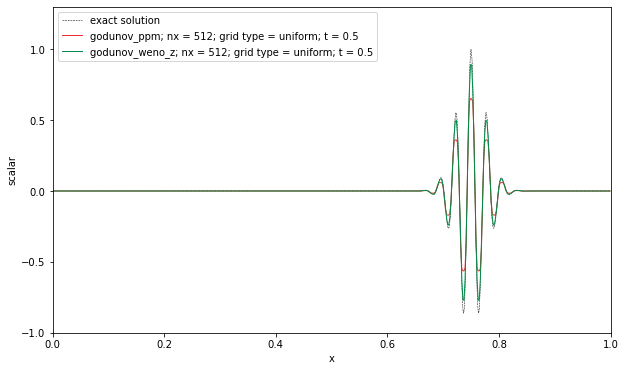

In [37]:
fig, ax = plt.subplots(figsize=(10, 6))

x_exact = np.linspace(0, 1, num=1000)
scalar_exact = [function(x_i,center,amplitude,width,eta,0.5) for x_i in x_exact]
ax.plot(x_exact,scalar_exact,color='black',label='exact solution',linewidth=lw_exact,linestyle=ls_exact)

postprocess_dist('yalla2021/eta_2',-1,root_dir,['godunov_ppm','godunov_weno_z'],['uniform'],[512],
                 ax,linestyle_list,color_list,[1.0],True,2)

ax.legend(loc='upper left')
ax.set_xlim([0,1])
ax.set_ylim([-1.0,1.3])
ax.set_xlabel('x')
ax.set_ylabel('scalar')

fig.savefig('4b-scalar_advection_uniform_final_godunov_ppm_weno_z.png')

yt : [INFO     ] 2022-08-07 13:02:43,783 Parameters: current_time              = 0.5
yt : [INFO     ] 2022-08-07 13:02:43,786 Parameters: domain_dimensions         = [512   4   4]
yt : [INFO     ] 2022-08-07 13:02:43,793 Parameters: domain_left_edge          = [ 0.         -0.00390625 -0.00390625]
yt : [INFO     ] 2022-08-07 13:02:43,800 Parameters: domain_right_edge         = [1.         0.00390625 0.00390625]
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421:

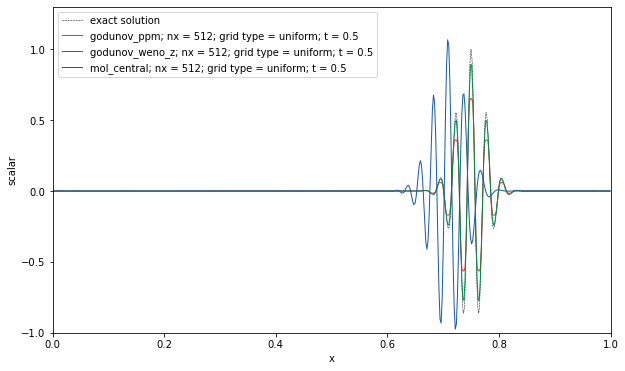

In [36]:
fig, ax = plt.subplots(figsize=(10, 6))

x_exact = np.linspace(0, 1, num=1000)
scalar_exact = [function(x_i,center,amplitude,width,eta,0.5) for x_i in x_exact]
ax.plot(x_exact,scalar_exact,color='black',label='exact solution',linewidth=lw_exact,linestyle=ls_exact)

postprocess_dist('yalla2021/eta_2',-1,root_dir,['godunov_ppm','godunov_weno_z','mol_central'],['uniform'],[512],
                 ax,linestyle_list,color_list,[1.0],True,2)

ax.legend(loc='upper left')
ax.set_xlim([0,1])
ax.set_ylim([-1.0,1.3])
ax.set_xlabel('x')
ax.set_ylabel('scalar')

fig.savefig('4c-scalar_advection_uniform_final_godunov_ppm_weno_z_mol_central.png')

### Errors

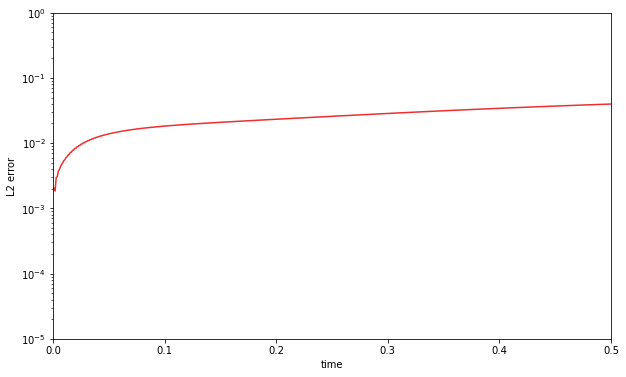

In [177]:
fig, ax = plt.subplots(figsize=(10, 6))
postprocess_error('yalla2021/eta_2',0.5,root_dir,['godunov_ppm'],['uniform'],[512],
                 ax,linestyle_list,color_list,linewidth_list,True,2)

ax.set_xlabel('time')
ax.set_ylabel('L2 error')
ax.set_xlim([0,0.5])
ax.set_ylim([1e-5,1])
ax.set_yscale('log')

fig.savefig('5a-scalar_advection_uniform_error_godunov_ppm.png')

In [159]:
%%capture
plt.rcParams["animation.html"] = "jshtml"

fig = plt.figure()
ax = plt.axes(xlim=(0, 0.5), ylim=(1e-5,1))
ax.set_xlabel('t')
ax.set_ylabel('L2 error')
ax.set_yscale('log')

line = ax.plot([],[],color='red',label='godunov_ppm; nx = 512; grid type = uniform;',linewidth=1.0,linestyle='solid')[0]

def init():
    line.set_data([],[])
    return line,
def animate(i):
    t,e = postprocess_error('yalla2021/eta_2',t_list[i],root_dir,['godunov_ppm'],['uniform'],[512],
                 ax,linestyle_list,color_list,linewidth_list,False,1)
    line.set_data(t,e)
    return line,

anim = FuncAnimation(fig, animate, init_func=init, frames=len(t_list), interval=200, blit=True)
anim.save('5a-scalar_advection_uniform_error_godunov_ppm.gif')

In [160]:
anim

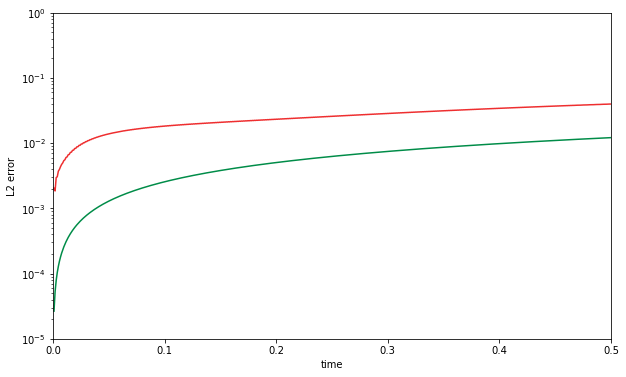

In [178]:
fig, ax = plt.subplots(figsize=(10, 6))
postprocess_error('yalla2021/eta_2',0.5,root_dir,['godunov_ppm','godunov_weno_z'],['uniform'],[512],
                 ax,linestyle_list,color_list,linewidth_list,True,2)

ax.set_xlabel('time')
ax.set_ylabel('L2 error')
ax.set_ylim([1e-5,1])
ax.set_xlim([0,0.5])
ax.set_yscale('log')

fig.savefig('5b-scalar_advection_uniform_error_godunov_ppm_weno_z.png')

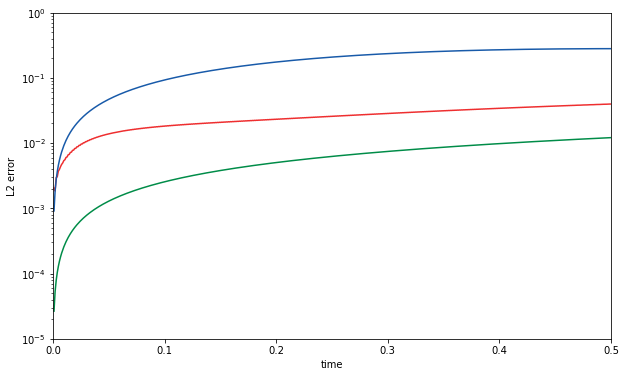

In [179]:
fig, ax = plt.subplots(figsize=(10, 6))
postprocess_error('yalla2021/eta_2',0.5,root_dir,['godunov_ppm','godunov_weno_z','mol_central'],['uniform'],[512],
                 ax,linestyle_list,color_list,linewidth_list,True,2)

ax.set_xlabel('time')
ax.set_ylabel('L2 error')
ax.set_ylim([1e-5,1])
ax.set_xlim([0,0.5])
ax.set_yscale('log')

fig.savefig('5c-scalar_advection_uniform_error_godunov_ppm_weno_z_mol_central.png')

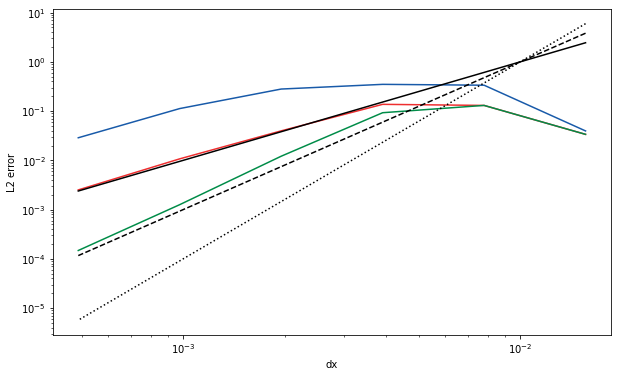

In [163]:
grid_sizes = [64,128,256,512,1024,2048]
fig, ax = plt.subplots(figsize=(10, 6))
postprocess_convergence('yalla2021/eta_2',0,root_dir,['godunov_ppm','godunov_weno_z','mol_central'],['uniform'],grid_sizes,
                 ax,['solid','solid','solid'],color_list,linewidth_list,2)
dx_list = [1.0/grid_size for grid_size in grid_sizes]
ax.plot(dx_list,[1e4*dx**2 for dx in dx_list],label='dx^2',linestyle='solid',color='black')
ax.plot(dx_list,[1e6*dx**3 for dx in dx_list],label='dx^3',linestyle='dashed',color='black')
ax.plot(dx_list,[1e8*dx**4 for dx in dx_list],label='dx^4',linestyle='dotted',color='black')

ax.set_xlabel('dx')
ax.set_ylabel('L2 error')
ax.set_xscale('log')
ax.set_yscale('log')


fig.savefig('6-scalar_advection_uniform_error_convergence_all.png')

# Fine-to-coarse grid: different methods with nx = 512

yt : [INFO     ] 2022-08-07 14:08:26,111 Parameters: current_time              = 0.5004882299999965
yt : [INFO     ] 2022-08-07 14:08:26,113 Parameters: domain_dimensions         = [512   4   4]
yt : [INFO     ] 2022-08-07 14:08:26,118 Parameters: domain_left_edge          = [ 0.         -0.00390625 -0.00390625]
yt : [INFO     ] 2022-08-07 14:08:26,125 Parameters: domain_right_edge         = [1.         0.00390625 0.00390625]
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_cont

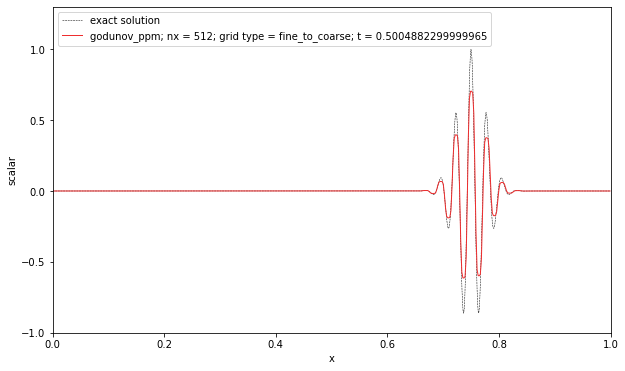

In [166]:
fig, ax = plt.subplots(figsize=(10, 6))

x_exact = np.linspace(0, 1, num=1000)
scalar_exact = [function(x_i,center,amplitude,width,eta,0.5) for x_i in x_exact]
ax.plot(x_exact,scalar_exact,color='black',label='exact solution',linewidth=lw_exact,linestyle=ls_exact)

postprocess_dist('yalla2021/eta_2',-1,root_dir,['godunov_ppm'],['fine_to_coarse'],[512],
                 ax,linestyle_list,color_list,[1.0],True,2)

ax.legend(loc='upper left')
ax.set_xlim([0,1])
ax.set_ylim([-1.0,1.3])
ax.set_xlabel('x')
ax.set_ylabel('scalar')

fig.savefig('6a-scalar_advection_refined_final_godunov_ppm.png')

MovieWriter ffmpeg unavailable; using Pillow instead.
yt : [INFO     ] 2022-08-07 14:10:19,443 Parameters: current_time              = 0.0
yt : [INFO     ] 2022-08-07 14:10:19,445 Parameters: domain_dimensions         = [512   4   4]
yt : [INFO     ] 2022-08-07 14:10:19,450 Parameters: domain_left_edge          = [ 0.         -0.00390625 -0.00390625]
yt : [INFO     ] 2022-08-07 14:10:19,456 Parameters: domain_right_edge         = [1.         0.00390625 0.00390625]
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/

yt : [INFO     ] 2022-08-07 14:10:39,034 Parameters: current_time              = 0.15624998399999937
yt : [INFO     ] 2022-08-07 14:10:39,036 Parameters: domain_dimensions         = [512   4   4]
yt : [INFO     ] 2022-08-07 14:10:39,038 Parameters: domain_left_edge          = [ 0.         -0.00390625 -0.00390625]
yt : [INFO     ] 2022-08-07 14:10:39,042 Parameters: domain_right_edge         = [1.         0.00390625 0.00390625]
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_con

yt : [INFO     ] 2022-08-07 14:10:58,418 Parameters: current_time              = 0.3124999679999981
yt : [INFO     ] 2022-08-07 14:10:58,420 Parameters: domain_dimensions         = [512   4   4]
yt : [INFO     ] 2022-08-07 14:10:58,425 Parameters: domain_left_edge          = [ 0.         -0.00390625 -0.00390625]
yt : [INFO     ] 2022-08-07 14:10:58,431 Parameters: domain_right_edge         = [1.         0.00390625 0.00390625]
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_cont

yt : [INFO     ] 2022-08-07 14:11:16,890 Parameters: current_time              = 0.46874995199999675
yt : [INFO     ] 2022-08-07 14:11:16,892 Parameters: domain_dimensions         = [512   4   4]
yt : [INFO     ] 2022-08-07 14:11:16,896 Parameters: domain_left_edge          = [ 0.         -0.00390625 -0.00390625]
yt : [INFO     ] 2022-08-07 14:11:16,901 Parameters: domain_right_edge         = [1.         0.00390625 0.00390625]
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_con

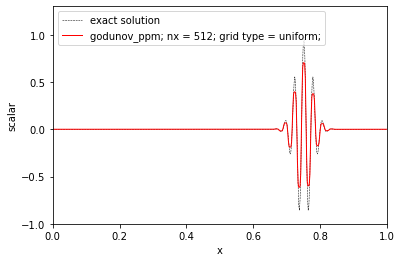

In [169]:
# %%capture
plt.rcParams["animation.html"] = "jshtml"

x_exact = np.linspace(0, 1, num=500)
n_frames = 18

fig = plt.figure()
ax = plt.axes(xlim=(0, 1), ylim=(-1, 1.3))
ax.set_xlabel('x')
ax.set_ylabel('scalar')

lines = []
line1 = ax.plot([],[],color='black',label='exact solution',linewidth=lw_exact,linestyle=ls_exact)[0]
lines.append(line1)
line2 = ax.plot([],[],color='red',label='godunov_ppm; nx = 512; grid type = uniform;',linewidth=1.0,linestyle='solid')[0]
lines.append(line2)
ax.legend(loc='upper left')

t_list = [0.0 for i in range(n_frames)]

def init():
    for line in lines:
        line.set_data([],[])
    return lines

def animate(i):
    t,x,s = postprocess_dist('yalla2021/eta_2',i,root_dir,['godunov_ppm'],['fine_to_coarse'],[512],
                 ax,linestyle_list,color_list,[1.0],False,2)
    t_list[i] = t
    lines[1].set_data(x,s)
    scalar_exact = [function(x_i,center,amplitude,width,eta,t) for x_i in x_exact]
    lines[0].set_data(x_exact,scalar_exact)
    return lines

anim = FuncAnimation(fig, animate, init_func=init, frames=n_frames, interval=200, blit=True)
anim.save('6a-scalar_advection_refined_final_godunov_ppm.gif')

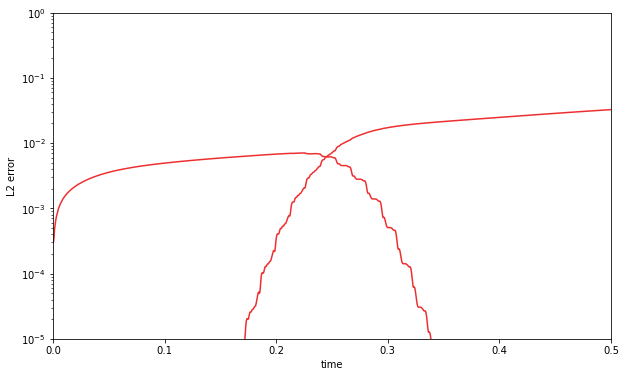

In [180]:
fig, ax = plt.subplots(figsize=(10, 6))
postprocess_error('yalla2021/eta_2',0.5,root_dir,['godunov_ppm'],['fine_to_coarse'],[512],
                 ax,linestyle_list,color_list,linewidth_list,True,2)

ax.set_xlabel('time')
ax.set_ylabel('L2 error')
ax.set_ylim([1e-5,1])
ax.set_xlim([0,0.5])

ax.set_yscale('log')

fig.savefig('7a-scalar_advection_refined_error_godunov_ppm.png')

In [189]:
%%capture
plt.rcParams["animation.html"] = "jshtml"

fig = plt.figure()
ax = plt.axes(xlim=(0, 0.5), ylim=(1e-5,1))
ax.set_xlabel('t')
ax.set_ylabel('L2 error')
ax.set_yscale('log')

line1 = ax.plot([],[],color='red',label='godunov_ppm; nx = 512; grid type = fine_to_coarse;',linewidth=1.0,linestyle='solid')[0]
line2 = ax.plot([],[],color='red',linewidth=1.0,linestyle='solid')[0]
lines = [line1,line2]

def init():
    lines[0].set_data([],[])
    lines[1].set_data([],[])
    return lines
def animate(i):
    t,e = postprocess_error('yalla2021/eta_2',t_list[i],root_dir,['godunov_ppm'],['fine_to_coarse'],[512],
                 ax,linestyle_list,color_list,linewidth_list,False,1)
    lines[0].set_data(t,e[0])
    lines[1].set_data(t,e[1])

    return lines

anim = FuncAnimation(fig, animate, init_func=init, frames=len(t_list), interval=200, blit=True)
# anim.save('7a-scalar_advection_refined_error_godunov_ppm.gif')

In [190]:
anim

yt : [INFO     ] 2022-08-07 14:39:21,456 Parameters: current_time              = 0.5004882299999965
yt : [INFO     ] 2022-08-07 14:39:21,462 Parameters: domain_dimensions         = [512   4   4]
yt : [INFO     ] 2022-08-07 14:39:21,467 Parameters: domain_left_edge          = [ 0.         -0.00390625 -0.00390625]
yt : [INFO     ] 2022-08-07 14:39:21,474 Parameters: domain_right_edge         = [1.         0.00390625 0.00390625]
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_cont

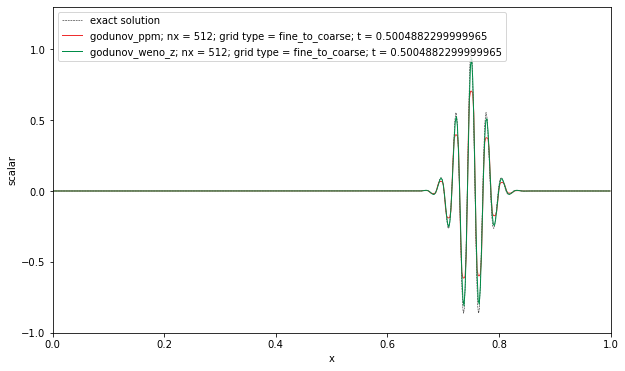

In [192]:
fig, ax = plt.subplots(figsize=(10, 6))

x_exact = np.linspace(0, 1, num=1000)
scalar_exact = [function(x_i,center,amplitude,width,eta,0.5) for x_i in x_exact]
ax.plot(x_exact,scalar_exact,color='black',label='exact solution',linewidth=lw_exact,linestyle=ls_exact)

postprocess_dist('yalla2021/eta_2',-1,root_dir,['godunov_ppm','godunov_weno_z'],['fine_to_coarse'],[512],
                 ax,linestyle_list,color_list,[1.0],True,2)

ax.legend(loc='upper left')
ax.set_xlim([0,1])
ax.set_ylim([-1.0,1.3])
ax.set_xlabel('x')
ax.set_ylabel('scalar')

fig.savefig('6b-scalar_advection_refined_final_godunov_ppm_weno_z.png')

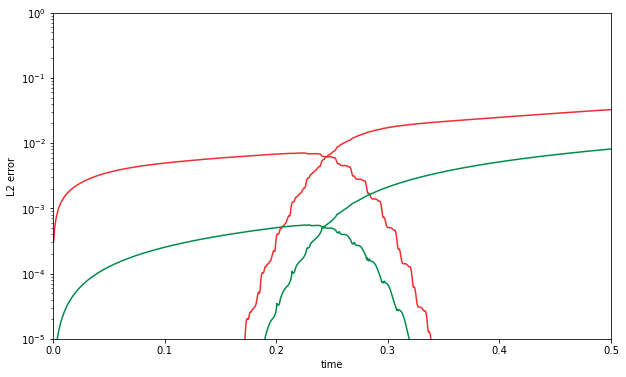

In [191]:
fig, ax = plt.subplots(figsize=(10, 6))
postprocess_error('yalla2021/eta_2',0.5,root_dir,['godunov_ppm','godunov_weno_z'],['fine_to_coarse'],[512],
                 ax,linestyle_list,color_list,linewidth_list,True,2)

ax.set_xlabel('time')
ax.set_ylabel('L2 error')
ax.set_ylim([1e-5,1])
ax.set_xlim([0,0.5])
ax.set_yscale('log')

fig.savefig('7b-scalar_advection_refined_error_godunov_ppm_weno_z.png')

yt : [INFO     ] 2022-08-07 14:40:18,801 Parameters: current_time              = 0.5004882299999965
yt : [INFO     ] 2022-08-07 14:40:18,804 Parameters: domain_dimensions         = [512   4   4]
yt : [INFO     ] 2022-08-07 14:40:18,807 Parameters: domain_left_edge          = [ 0.         -0.00390625 -0.00390625]
yt : [INFO     ] 2022-08-07 14:40:18,812 Parameters: domain_right_edge         = [1.         0.00390625 0.00390625]
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_cont

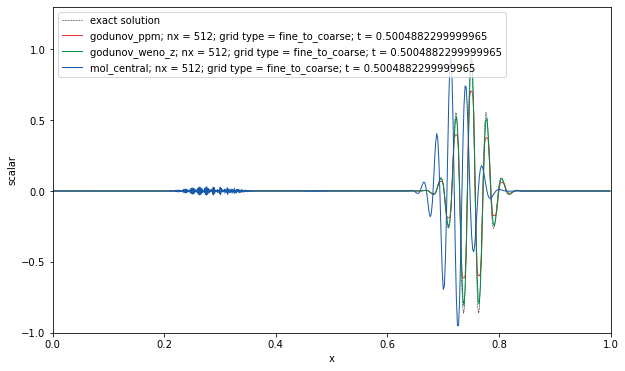

In [193]:
fig, ax = plt.subplots(figsize=(10, 6))

x_exact = np.linspace(0, 1, num=1000)
scalar_exact = [function(x_i,center,amplitude,width,eta,0.5) for x_i in x_exact]
ax.plot(x_exact,scalar_exact,color='black',label='exact solution',linewidth=lw_exact,linestyle=ls_exact)

postprocess_dist('yalla2021/eta_2',-1,root_dir,['godunov_ppm','godunov_weno_z','mol_central'],['fine_to_coarse'],[512],
                 ax,linestyle_list,color_list,[1.0],True,2)

ax.legend(loc='upper left')
ax.set_xlim([0,1])
ax.set_ylim([-1.0,1.3])
ax.set_xlabel('x')
ax.set_ylabel('scalar')

fig.savefig('6c-scalar_advection_refined_final_godunov_ppm_weno_z_mol_central.png')

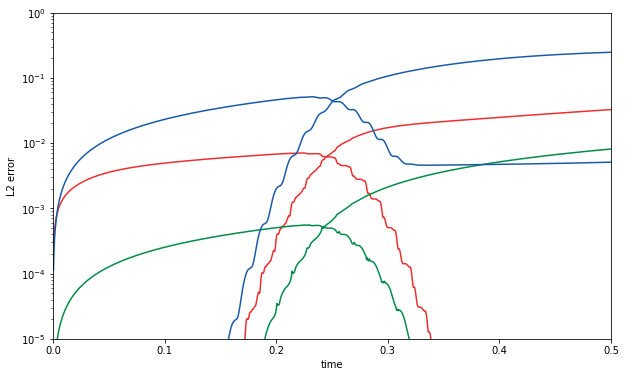

In [194]:
fig, ax = plt.subplots(figsize=(10, 6))
postprocess_error('yalla2021/eta_2',0.5,root_dir,['godunov_ppm','godunov_weno_z','mol_central'],['fine_to_coarse'],[512],
                 ax,linestyle_list,color_list,linewidth_list,True,2)

ax.set_xlabel('time')
ax.set_ylabel('L2 error')
ax.set_ylim([1e-5,1])
ax.set_xlim([0,0.5])
ax.set_yscale('log')

fig.savefig('7b-scalar_advection_refined_error_godunov_ppm_weno_z_mol_central.png')

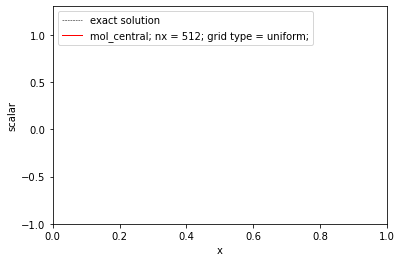

In [199]:
# %%capture
plt.rcParams["animation.html"] = "jshtml"

x_exact = np.linspace(0, 1, num=500)
n_frames = 18

fig = plt.figure()
ax = plt.axes(xlim=(0, 1), ylim=(-1, 1.3))
ax.set_xlabel('x')
ax.set_ylabel('scalar')

lines = []
line1 = ax.plot([],[],color='black',label='exact solution',linewidth=lw_exact,linestyle=ls_exact)[0]
lines.append(line1)
line2 = ax.plot([],[],color=[color_list[2]],label='mol_central; nx = 512; grid type = uniform;',linewidth=1.0,linestyle='solid')[0]
lines.append(line2)
ax.legend(loc='upper left')

t_list = [0.0 for i in range(n_frames)]

def init():
    for line in lines:
        line.set_data([],[])
    return lines

def animate(i):
    t,x,s = postprocess_dist('yalla2021/eta_2',i,root_dir,['mol_central'],['fine_to_coarse'],[512],
                 ax,linestyle_list,[color_list[2]],[1.0],False,2)
    t_list[i] = t
    lines[1].set_data(x,s)
    scalar_exact = [function(x_i,center,amplitude,width,eta,t) for x_i in x_exact]
    lines[0].set_data(x_exact,scalar_exact)
    return lines

anim = FuncAnimation(fig, animate, init_func=init, frames=n_frames, interval=200, blit=True)
# anim.save('6d-scalar_advection_refined_final_mol_central.gif')

In [200]:
anim

yt : [INFO     ] 2022-08-07 14:45:19,099 Parameters: current_time              = 0.0
yt : [INFO     ] 2022-08-07 14:45:19,102 Parameters: domain_dimensions         = [512   4   4]
yt : [INFO     ] 2022-08-07 14:45:19,109 Parameters: domain_left_edge          = [ 0.         -0.00390625 -0.00390625]
yt : [INFO     ] 2022-08-07 14:45:19,122 Parameters: domain_right_edge         = [1.         0.00390625 0.00390625]
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421:

yt : [INFO     ] 2022-08-07 14:45:37,920 Parameters: current_time              = 0.15624998399999937
yt : [INFO     ] 2022-08-07 14:45:37,922 Parameters: domain_dimensions         = [512   4   4]
yt : [INFO     ] 2022-08-07 14:45:37,927 Parameters: domain_left_edge          = [ 0.         -0.00390625 -0.00390625]
yt : [INFO     ] 2022-08-07 14:45:37,930 Parameters: domain_right_edge         = [1.         0.00390625 0.00390625]
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_con

yt : [INFO     ] 2022-08-07 14:45:56,239 Parameters: current_time              = 0.3124999679999981
yt : [INFO     ] 2022-08-07 14:45:56,241 Parameters: domain_dimensions         = [512   4   4]
yt : [INFO     ] 2022-08-07 14:45:56,244 Parameters: domain_left_edge          = [ 0.         -0.00390625 -0.00390625]
yt : [INFO     ] 2022-08-07 14:45:56,246 Parameters: domain_right_edge         = [1.         0.00390625 0.00390625]
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_cont

yt : [INFO     ] 2022-08-07 14:46:15,634 Parameters: current_time              = 0.46874995199999675
yt : [INFO     ] 2022-08-07 14:46:15,636 Parameters: domain_dimensions         = [512   4   4]
yt : [INFO     ] 2022-08-07 14:46:15,641 Parameters: domain_left_edge          = [ 0.         -0.00390625 -0.00390625]
yt : [INFO     ] 2022-08-07 14:46:15,644 Parameters: domain_right_edge         = [1.         0.00390625 0.00390625]
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_con

In [201]:
%%capture
plt.rcParams["animation.html"] = "jshtml"

fig = plt.figure()
ax = plt.axes(xlim=(0, 0.5), ylim=(1e-5,1))
ax.set_xlabel('t')
ax.set_ylabel('L2 error')
ax.set_yscale('log')

line1 = ax.plot([],[],color=[color_list[2]],label='mol_central; nx = 512; grid type = fine_to_coarse;',linewidth=1.0,linestyle='solid')[0]
line2 = ax.plot([],[],color=[color_list[2]],linewidth=1.0,linestyle='solid')[0]
lines = [line1,line2]

def init():
    lines[0].set_data([],[])
    lines[1].set_data([],[])
    return lines
def animate(i):
    t,e = postprocess_error('yalla2021/eta_2',t_list[i],root_dir,['mol_central'],['fine_to_coarse'],[512],
                 ax,linestyle_list,[color_list[2]],linewidth_list,False,1)
    lines[0].set_data(t,e[0])
    lines[1].set_data(t,e[1])

    return lines

anim = FuncAnimation(fig, animate, init_func=init, frames=len(t_list), interval=200, blit=True)
# anim.save('7d-scalar_advection_refined_error_mol_central.gif')

In [202]:
anim

# Fine-to-coarse grid: tophat

In [210]:
center = 0.25
amplitude = 1.0
# width = 0.0251646060
width = 0.05
# width = 0.01
# eta = 226.1946710304
# t_final = 0.5
function = tophat

yt : [INFO     ] 2022-08-07 14:56:27,397 Parameters: current_time              = 0.0
yt : [INFO     ] 2022-08-07 14:56:27,399 Parameters: domain_dimensions         = [512   4   4]
yt : [INFO     ] 2022-08-07 14:56:27,406 Parameters: domain_left_edge          = [ 0.         -0.00390625 -0.00390625]
yt : [INFO     ] 2022-08-07 14:56:27,413 Parameters: domain_right_edge         = [1.         0.00390625 0.00390625]
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421:

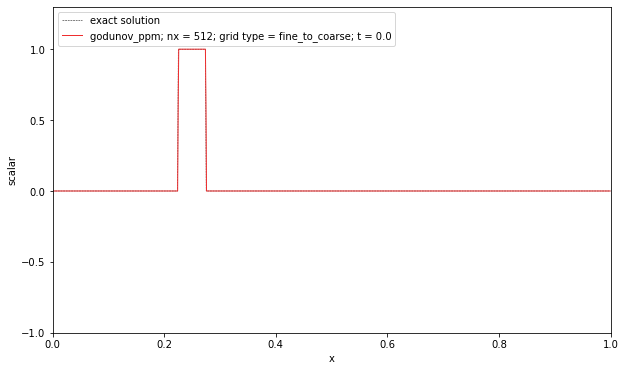

In [212]:
fig, ax = plt.subplots(figsize=(10, 6))

x_exact = np.linspace(0, 1, num=1000)
scalar_exact = [function(x_i,center,amplitude,width,eta,0) for x_i in x_exact]
ax.plot(x_exact,scalar_exact,color='black',label='exact solution',linewidth=lw_exact,linestyle=ls_exact)

postprocess_dist('tophat',0,root_dir,['godunov_ppm'],['fine_to_coarse'],[512],
                 ax,linestyle_list,color_list,[1.0],True,2)

ax.legend(loc='upper left')
ax.set_xlim([0,1])
ax.set_ylim([-1.0,1.3])
ax.set_xlabel('x')
ax.set_ylabel('scalar')

fig.savefig('8a-scalar_advection_refined_error_godunov_ppm_tophat_initial.png')

yt : [INFO     ] 2022-08-07 14:54:23,238 Parameters: current_time              = 0.5004882299999965
yt : [INFO     ] 2022-08-07 14:54:23,240 Parameters: domain_dimensions         = [512   4   4]
yt : [INFO     ] 2022-08-07 14:54:23,245 Parameters: domain_left_edge          = [ 0.         -0.00390625 -0.00390625]
yt : [INFO     ] 2022-08-07 14:54:23,249 Parameters: domain_right_edge         = [1.         0.00390625 0.00390625]
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_cont

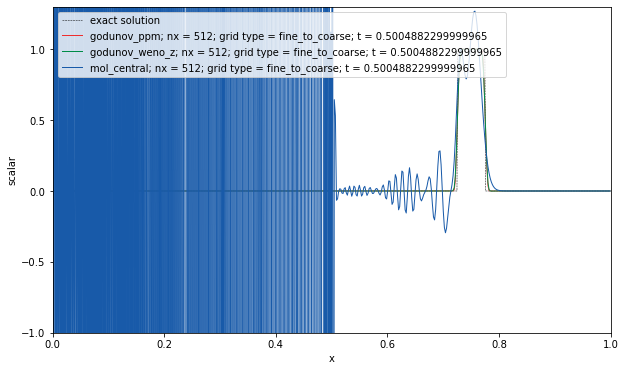

In [211]:
fig, ax = plt.subplots(figsize=(10, 6))

x_exact = np.linspace(0, 1, num=1000)
scalar_exact = [function(x_i,center,amplitude,width,eta,0.5) for x_i in x_exact]
ax.plot(x_exact,scalar_exact,color='black',label='exact solution',linewidth=lw_exact,linestyle=ls_exact)

postprocess_dist('tophat',-1,root_dir,['godunov_ppm','godunov_weno_z','mol_central'],['fine_to_coarse'],[512],
                 ax,linestyle_list,color_list,[1.0],True,2)

ax.legend(loc='upper left')
ax.set_xlim([0,1])
ax.set_ylim([-1.0,1.3])
ax.set_xlabel('x')
ax.set_ylabel('scalar')

fig.savefig('8b-scalar_advection_refined_error_godunov_ppm_weno_z_mol_central_tophat.png')

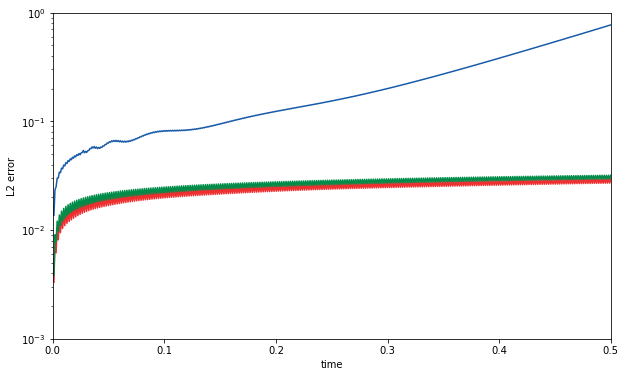

In [207]:
fig, ax = plt.subplots(figsize=(10, 6))
postprocess_error('tophat',0.5,root_dir,['godunov_ppm','godunov_weno_z','mol_central'],['uniform'],[512],
                 ax,linestyle_list,color_list,linewidth_list,True,2)

ax.set_xlabel('time')
ax.set_ylabel('L2 error')
ax.set_ylim([1e-3,1])
ax.set_xlim([0,0.5])
ax.set_yscale('log')

fig.savefig('9-scalar_advection_refined_error_godunov_ppm_weno_z_mol_central_tophat.png')

yt : [INFO     ] 2022-08-07 16:16:19,294 Parameters: current_time              = 0.34375
yt : [INFO     ] 2022-08-07 16:16:19,297 Parameters: domain_dimensions         = [128   4   4]
yt : [INFO     ] 2022-08-07 16:16:19,301 Parameters: domain_left_edge          = [ 0.       -0.015625 -0.015625]
yt : [INFO     ] 2022-08-07 16:16:19,306 Parameters: domain_right_edge         = [1.       0.015625 0.015625]
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: Visible

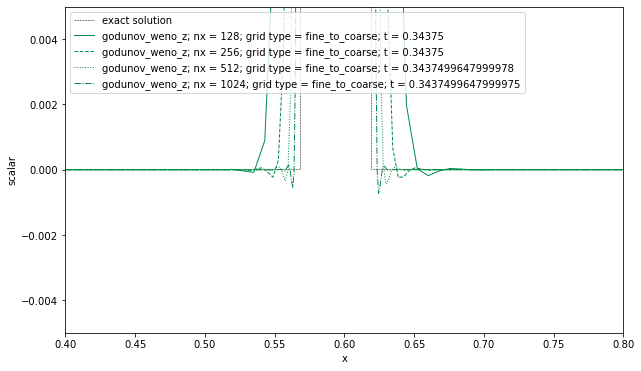

In [233]:
fig, ax = plt.subplots(figsize=(10, 6))

x_exact = np.linspace(0, 1, num=1000)
scalar_exact = [function(x_i,center,amplitude,width,eta,0.34375) for x_i in x_exact]
ax.plot(x_exact,scalar_exact,color='black',label='exact solution',linewidth=lw_exact,linestyle=ls_exact)

t,_,_ = postprocess_dist('tophat',11,root_dir,['godunov_weno_z'],['fine_to_coarse'],[128,256,512,1024],
                 ax,linestyle_list,[color_list[1]],[1.0],True,2)

ax.legend(loc='upper left')
ax.set_xlim([0.4,0.8])
ax.set_ylim([-0.005,0.005])
ax.set_xlabel('x')
ax.set_ylabel('scalar')

fig.savefig('10-scalar_advection_refined_error_godunov_weno_z_tophat.png')